<a href="https://colab.research.google.com/github/martincufino/MIAD_ML_NLP_2025/blob/main/S1TC1_arboles_ensamblajes_VF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

![image info](https://raw.githubusercontent.com/albahnsen/MIAD_ML_and_NLP/main/images/banner_1.png)

# Taller: Construcción e implementación de árboles de decisión y métodos de ensamblaje

En este taller podrá poner en práctica los sus conocimientos sobre construcción e implementación de árboles de decisión y métodos de ensamblajes. El taller está constituido por 9 puntos, 5 relacionados con árboles de decisión (parte A) y 4 con métodos de ensamblaje (parte B).

## Parte A - Árboles de decisión

En esta parte del taller se usará el conjunto de datos de Capital Bikeshare de Kaggle, donde cada observación representa el alquiler de bicicletas durante una hora y día determinado. Para más detalles puede visitar los siguientes enlaces: [datos](https://archive.ics.uci.edu/ml/machine-learning-databases/00275/Bike-Sharing-Dataset.zip), [dicccionario de datos](https://archive.ics.uci.edu/ml/datasets/Bike+Sharing+Dataset#).

### Datos prestamo de bicicletas

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# Importación de librerías
%matplotlib inline
import pandas as pd
import numpy as np
from sklearn.model_selection import cross_val_score, KFold, train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor, export_graphviz

In [ ]:
# Lectura de la información de archivo .csv
bikes = pd.read_csv('https://raw.githubusercontent.com/davidzarruk/MIAD_ML_NLP_2023/main/datasets/bikeshare.csv', index_col='datetime', parse_dates=True)

# Renombrar variable "count" a "total"
bikes.rename(columns={'count':'total'}, inplace=True)

# Crear la hora como una variable
bikes['hour'] = bikes.index.hour

# Visualización de los datos
bikes.head()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,total,hour
datetime,,,,,,,,,,,,
2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,0
2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,1
2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32,2
2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13,3
2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1,4


### Punto 1 - Análisis descriptivo

Ejecute las celdas 1.1 y 1.2. A partir de los resultados realice un análisis descriptivo sobre las variables "season" y "hour", escriba sus inferencias sobre los datos. Para complementar su análisis puede usar métricas como máximo, mínimo, percentiles entre otros.

In [ ]:
# Celda 1.1
bikes.groupby('season').total.mean()

,total
season,
1,116.343261
2,215.251372
3,234.417124
4,198.988296


In [ ]:
bikes['season'].describe()

,season
count,10886.000000
mean,2.506614
std,1.116174
min,1.000000
25%,2.000000
50%,3.000000
75%,4.000000
max,4.000000


In [ ]:
# Celda 1.2
bikes.groupby('hour').total.mean()

,total
hour,
0,55.138462
1,33.859031
2,22.899554
3,11.757506
4,6.407240
5,19.767699
6,76.259341
7,213.116484
8,362.769231


In [ ]:
bikes['hour'].describe()

,hour
count,10886.000000
mean,11.541613
std,6.915838
min,0.000000
25%,6.000000
50%,12.000000
75%,18.000000
max,23.000000


<Axes: xlabel='season', ylabel='hour'>

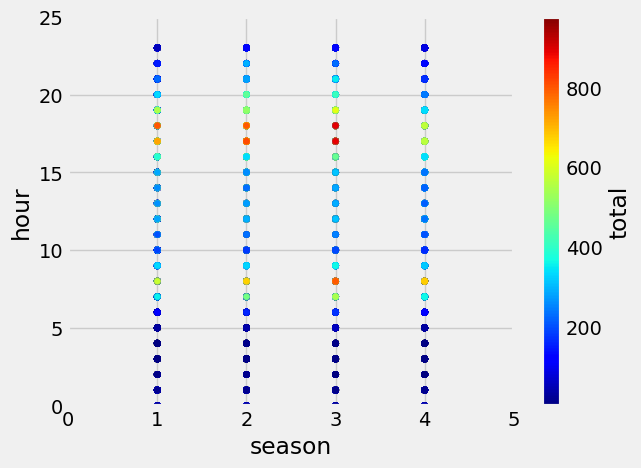

In [ ]:
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
bikes.plot(kind='scatter', x='season', y='hour', c='total', colormap='jet', xlim=(0, 5), ylim=(0, 25))

#### **ANALISIS DESCRIPTIVO**

1. La variable Season nos indica una temporada o estacion del año,donde se evidencia analizando sus quartiles que la mayoria de los datos se encuentran entre 3 y 4, adicional el promedio de esta variable es 2.51 lo que indica una inclinacion hacia la segunda mitad del año, asumiendo que el año se divide en estas 4 partes.

2. Analizado la variable Total, que nos indica el numero de bicicletas rentadas, podemos observar que al segregar esta variable por la temporada, encontramos que la temporada 1 tiene en promedio la menor cantidad de bicicletas alquiladas mientras que la 3 la mayor.

3. La variable hour nos indica las horas del dia y podemos evidenciar la cantidad promedio de bicicletas rentadas en cada hora, asi podemos concluir que la minima demanda se encuentra entre las 0 y las 5 horas, que se infiere que son las horas de la madrugada, asi mismo se ve un incremento progresivo de la demanda a partir de las 6am (76.2), encontrando asi dos picos en el alquiler de bicicletas, el primero a las 8am (362.7) que tiene sentido asumiendo que es la hora de entrada de muchos trabjadores, y el siguiente es a partir de las 5pm (468.7) que indica la hora de salida de las personas que utilizan el servicio.

4. La estadistica inferencial de esta variable nos sugiere que la mediana es a las 12, lo cual indica que la mitad de los valores ocurre antes y la otra mitad despues del medio dia, el promedio es de 11.5, lo que sugiere que se hace mas uso en horas de la mañana y la desviacion estandar de 6.9 horas indica que entre los horarios hay alta variabilidad.

### Punto 2 - Análisis de gráficos

Primero ejecute la celda 2.1 y asegúrese de comprender el código y el resultado. Luego, en cada una de celdas 2.2 y 2.3 escriba un código que genere una gráfica del número de bicicletas rentadas promedio para cada valor de la variable "hour" (hora) cuando la variable "season" es igual a 1 (invierno) e igual a 3 (verano), respectivamente. Analice y escriba sus hallazgos.

<Axes: xlabel='hour'>

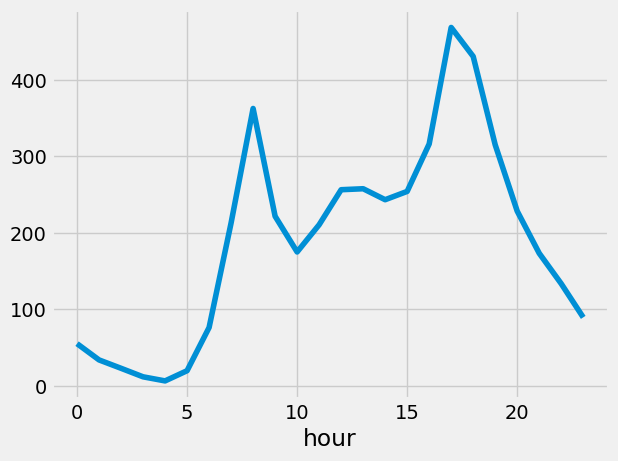

In [ ]:
# Celda 2.1 - rentas promedio para cada valor de la variable "hour"
bikes.groupby('hour').total.mean().plot()

<Axes: title={'center': 'Uso de bicicletas en invierno (Season 1)'}, xlabel='hour'>

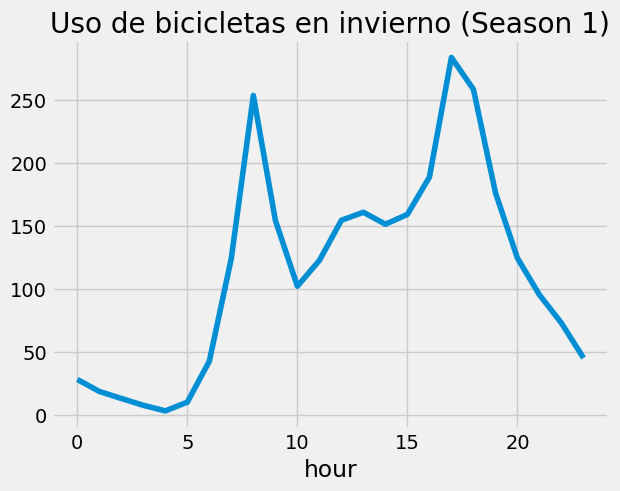

In [ ]:
# Celda 2.2 - "season"=1 escriba su código y hallazgos
bikes[bikes['season'] == 1].groupby('hour').total.mean().plot(title="Uso de bicicletas en invierno (Season 1)")

<Axes: title={'center': 'Uso de bicicletas en verano (Season 3)'}, xlabel='hour'>

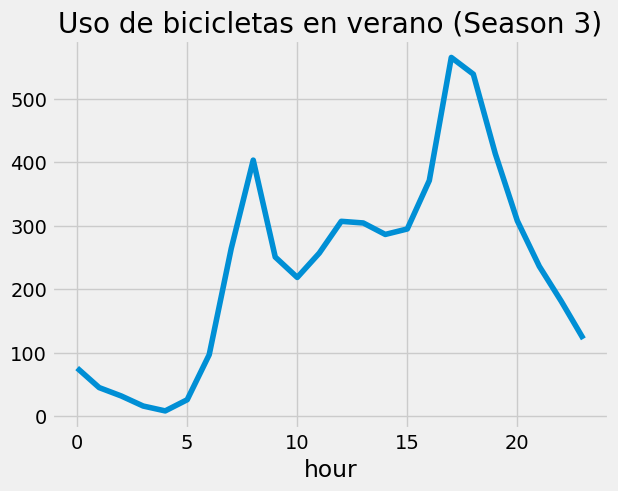

In [ ]:
# Celda 2.3 - "season"=3 escriba su código y hallazgos
bikes[bikes['season'] == 3].groupby('hour').total.mean().plot(title="Uso de bicicletas en verano (Season 3)")

#### **ANALISIS**
Al hacer una revision de las graficas vemos que tanto en la season 1 como en la 3 tienen un comportamiento similar durante el dia, pues vemos los mismos patrones de picos y valles.

Sin embargo cambia la cantidad de bicicletas rentadas, mientras que en la season 1 el pico maximo es de 250 bicicletas, en la season 3 es de 550 aproximadamente, lo que indica una mayor demanda en la season 3.

### Punto 3 - Regresión lineal
En la celda 3 ajuste un modelo de regresión lineal a un conjunto de train de datos, utilizando "total" como variable de respuesta y "season" y "hour" como las únicas variables predictoras, teniendo en cuenta que la variable "season" es categórica. Luego, imprima los coeficientes e interprételos. ¿Cuáles son las limitaciones de la regresión lineal en este caso?

In [ ]:
# Celda 3

# Convertir 'season' en variables dummy
bikes_dummies = pd.get_dummies(bikes, columns=['season'], drop_first=True)

# Definir variables predictoras (X) y respuesta (y)
X = bikes_dummies[['hour', 'season_2', 'season_3', 'season_4']]
y = bikes_dummies['total']

# Dividir datos en entrenamiento (80%) y prueba (20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Configurar validación cruzada con K=5
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Modelo de regresión lineal
modelo = LinearRegression()

# Validación cruzada en el conjunto de entrenamiento
scores = cross_val_score(modelo, X_train, y_train, cv=kf, scoring='r2')

# Entrenar el modelo en los datos de entrenamiento
modelo.fit(X_train, y_train)

# Evaluar el modelo en los datos de prueba
r2_test = modelo.score(X_test, y_test)

# Obtener coeficientes
coeficientes = pd.DataFrame({'Variable': X.columns, 'Coeficiente': modelo.coef_})

# Imprimir resultados
print(f'Scores de validación cruzada en train (R^2 por fold): {scores}')
print(f'Media del R^2 en train: {np.mean(scores):.4f}')
print(f'Desviación estándar del R^2 en train: {np.std(scores):.4f}')
print(f'R^2 en test: {r2_test:.4f}')
print("\nCoeficientes del modelo:")
print(coeficientes)


Scores de validación cruzada en train (R^2 por fold): [0.2152382  0.20477677 0.21752469 0.22028669 0.24599299]
Media del R^2 en train: 0.2208
Desviación estándar del R^2 en train: 0.0137
R^2 en test: 0.2302

Coeficientes del modelo:
   Variable  Coeficiente
0      hour    10.569619
1  season_2    99.106671
2  season_3   116.046340
3  season_4    84.944802


Los resultados indican un R2 bastante bajo, pues explican aproximadamente 23% de la variabilidad de los datos. La principal limitacion es que no se tienen en cuenta otras variables que pueden explicar la variable a predecir de cantidad de bicicletas rentadas, ademas puede que las relaciones entre estas variables no sean lineales.

### Punto 4 - Árbol de decisión manual
En la celda 4 cree un árbol de decisiones para pronosticar la variable "total" iterando **manualmente** sobre las variables "hour" y  "season". El árbol debe tener al menos 6 nodos finales.

In [ ]:
# Celda 4

X = bikes[['hour', 'season']]
y = bikes['total']

# Definición de parámetros y criterios de parada
max_depth = None
num_pct = 10
max_features = None
min_gain=0.001

# Impresión variable a usar (hour)
columns = [0,1]

for j in columns:
  print(X.columns[j])

  # División de la variable hour en num_ctp puntos (parámetro definido anteriormente) para obtener posibles puntos de corte
  splits = np.percentile(X.iloc[:, j], np.arange(0, 100, 100.0 / num_pct).tolist())
  splits = np.unique(splits)
  print(f"splits: {splits}")

  # División de las observaciones usando el punto de corte en la posición 5 de la lista de splits

  k=3
  filter_l = X.iloc[:, j] < splits[k]

  # División de la variable de respuesta de acuerdo a si la observación cumple o no con la regla binaria
  # y_l: la observación tiene un valor menor al punto de corte seleccionado
  # y_r: la observación tiene un valor mayor o igual al punto de corte seleccionado
  y_l = y.loc[filter_l]
  y_r = y.loc[~filter_l]

  # Definición de la función que calcula el gini index
  def gini(y):
      if y.shape[0] == 0:
          return 0
      p = np.bincount(y) / len(y)
      return 1 - np.sum(p ** 2)

  # Gini index de las observaciones que tienen un valor menor al punto de corte seleccionado
  gini_l = gini(y_l)
  print(f"gini_l: {gini_l}")

  # Gini index de las observaciones que tienen un valor mayor o igual al punto de corte seleccionado
  gini_r = gini(y_r)
  print(f"gini_r: {gini_r}")

  # Definición de la función gini_imputiry para calular la ganancia de una variable predictora j dado el punto de corte k
  def gini_impurity(X_col, y, split):

      filter_l = X_col < split
      y_l = y.loc[filter_l]
      y_r = y.loc[~filter_l]

      n_l = y_l.shape[0]
      n_r = y_r.shape[0]

      gini_y = gini(y)
      gini_l = gini(y_l)
      gini_r = gini(y_r)

      gini_impurity_ = gini_y - (n_l / (n_l + n_r) * gini_l + n_r / (n_l + n_r) * gini_r)

      return gini_impurity_

  # Ganancia de la variable 'Hits' en el punto de corte selecionado
  gini_impurity(X.iloc[:, j], y, splits[k])
  print(f"gini_impurity: {gini_impurity(X.iloc[:, j], y, splits[k])}")

hour
splits: [ 0.  2.  4.  7.  9. 12. 14. 16. 19. 21.]
gini_l: 0.9786426322658117
gini_r: 0.9979441985220977
gini_impurity: 0.004320202153336727
season
splits: [1. 2. 3. 4.]
gini_l: 0.9965692025702044
gini_r: 0.9965612255436833
gini_impurity: 0.00013155606150661026


In [ ]:
# Definición de la función best_split para calcular cuál es la mejor variable y punto de cortepara hacer la bifurcación del árbol
def best_split(X, y, num_pct=10):

    features = range(X.shape[1])

    best_split = [0, 0, 0]  # j, split, gain

    # Para todas las varibles
    for j in features:

        splits = np.percentile(X.iloc[:, j], np.arange(0, 100, 100.0 / (num_pct+1)).tolist())
        splits = np.unique(splits)[1:]

        # Para cada partición
        for split in splits:
            gain = gini_impurity(X.iloc[:, j], y, split)

            if gain > best_split[2]:
                best_split = [j, split, gain]

    return best_split

In [ ]:
# Obtención de la variable 'j', su punto de corte 'split' y su ganancia 'gain'
j = 1
# Uso de la función para obtener el mejor split
j, split, gain = best_split(X, y, 5)

# Impresión del resultado
print(f"Para la columna {X.columns[j]}, el mejor punto de corte es {split} con una ganancia de {gain}")

Para la columna hour, el mejor punto de corte es 8.0 con una ganancia de 0.00374870850413489


In [ ]:
# Obtención de la variable 'j', su punto de corte 'split' y su ganancia 'gain'
j, split, gain = best_split(X, y, 5)
# Impresión del resultado para cada columna
print(f"Para la columna {X.columns[j]}, el mejor punto de corte es {split} con una ganancia de {gain}")

Para la columna hour, el mejor punto de corte es 8.0 con una ganancia de 0.00374870850413489


In [ ]:
# División de las observaciones usando la mejor variable 'j' y su punto de corte 'split'
filter_l = X.iloc[:, j] < split

y_l = y.loc[filter_l]
y_r = y.loc[~filter_l]

In [ ]:
print(f"Total registros: {y.shape[0]}, l_split: {y_l.shape[0]}, r_split: {y_r.shape[0]}")

Total registros: 10886, l_split: 3594, r_split: 7292


In [ ]:
print(f"y_mean: {y.mean()}, y_l_mean: {y_l.mean()}, y_r_mean: {y_r.mean()}")

y_mean: 191.57413191254824, y_l_mean: 55.437673900946024, y_r_mean: 258.6715578716402


In [ ]:
# Definición de la función tree_grow para hacer un crecimiento recursivo del árbol
def tree_grow(X, y, level=0, min_gain=0.001, max_depth=None, num_pct=10):

    # Si solo es una observación
    if X.shape[0] == 1:
        tree = dict(y_pred=y.iloc[:1].values[0], y_prob=0.5, level=level, split=-1, n_samples=1, gain=0)
        return tree

    # Calcular la mejor división
    j, split, gain = best_split(X, y, num_pct)

    # Guardar el árbol y estimar la predicción
    y_pred = int(y.mean() >= 0.5)
    y_prob = (y.sum() + 1.0) / (y.shape[0] + 2.0)

    tree = dict(y_pred=y_pred, y_prob=y_prob, level=level, split=-1, n_samples=X.shape[0], gain=gain)
    # Revisar el criterio de parada
    if gain < min_gain:
        return tree
    if max_depth is not None:
        if level >= max_depth:
            return tree

    # Continuar creando la partición
    filter_l = X.iloc[:, j] < split
    X_l, y_l = X.loc[filter_l], y.loc[filter_l]
    X_r, y_r = X.loc[~filter_l], y.loc[~filter_l]
    tree['split'] = [j, split]

    # Siguiente iteración para cada partición

    tree['sl'] = tree_grow(X_l, y_l, level + 1, min_gain=min_gain, max_depth=max_depth, num_pct=num_pct)
    tree['sr'] = tree_grow(X_r, y_r, level + 1, min_gain=min_gain, max_depth=max_depth, num_pct=num_pct)

    return tree

In [ ]:
# Aplicación de la función tree_grow
tree_grow(X, y, level=0, min_gain=0.001, max_depth=1, num_pct=10)

{'y_pred': 1,
 'y_prob': np.float64(191.53903379867745),
 'level': 0,
 'split': [0, np.float64(6.0)],
 'n_samples': 10886,
 'gain': np.float64(0.004638190880114967),
 'sl': {'y_pred': 1,
  'y_prob': np.float64(25.15934475055845),
  'level': 1,
  'split': -1,
  'n_samples': 2684,
  'gain': np.float64(0.005307751859724874)},
 'sr': {'y_pred': 1,
  'y_prob': np.float64(245.96538274012676),
  'level': 1,
  'split': -1,
  'n_samples': 8202,
  'gain': np.float64(0.0004014539388822458)}}

In [ ]:
tree = tree_grow(X, y, level=0, min_gain=0.001, max_depth=3, num_pct=10)
tree

{'y_pred': 1,
 'y_prob': np.float64(191.53903379867745),
 'level': 0,
 'split': [0, np.float64(6.0)],
 'n_samples': 10886,
 'gain': np.float64(0.004638190880114967),
 'sl': {'y_pred': 1,
  'y_prob': np.float64(25.15934475055845),
  'level': 1,
  'split': [0, np.float64(2.0)],
  'n_samples': 2684,
  'gain': np.float64(0.005307751859724874),
  'sl': {'y_pred': 1,
   'y_prob': np.float64(44.41383095499451),
   'level': 2,
   'split': [1, np.float64(2.0)],
   'n_samples': 909,
   'gain': np.float64(0.0030073055330561704),
   'sl': {'y_pred': 1,
    'y_prob': np.float64(23.32456140350877),
    'level': 3,
    'split': -1,
    'n_samples': 226,
    'gain': np.float64(0.008810400187955203)},
   'sr': {'y_pred': 1,
    'y_prob': np.float64(51.3051094890511),
    'level': 3,
    'split': -1,
    'n_samples': 683,
    'gain': np.float64(0.0043991447016211715)}},
  'sr': {'y_pred': 1,
   'y_prob': np.float64(15.260551491277434),
   'level': 2,
   'split': [1, np.float64(2.0)],
   'n_samples': 177

In [ ]:
# Definición de la función tree_predict para hacer predicciones según las variables 'X' y el árbol 'tree'

def tree_predict(X, tree, proba=False):

    predicted = np.ones(X.shape[0])

    # Revisar si es el nodo final
    if tree['split'] == -1:
        if not proba:
            predicted = predicted * tree['y_pred']
        else:
            predicted = predicted * tree['y_prob']

    else:

        j, split = tree['split']
        filter_l = (X.iloc[:, j] < split)
        X_l = X.loc[filter_l]
        X_r = X.loc[~filter_l]

        if X_l.shape[0] == 0:  # Si el nodo izquierdo está vacio solo continua con el derecho
            predicted[~filter_l] = tree_predict(X_r, tree['sr'], proba)
        elif X_r.shape[0] == 0:  #  Si el nodo derecho está vacio solo continua con el izquierdo
            predicted[filter_l] = tree_predict(X_l, tree['sl'], proba)
        else:
            predicted[filter_l] = tree_predict(X_l, tree['sl'], proba)
            predicted[~filter_l] = tree_predict(X_r, tree['sr'], proba)

    return predicted

In [ ]:
# Ejecución de función tree_predict
tree_predict(X, tree)

array([1., 1., 1., ..., 1., 1., 1.])

### Punto 5 - Árbol de decisión con librería
En la celda 5 entrene un árbol de decisiones con la **librería sklearn**, usando las variables predictoras "season" y "hour" y calibre los parámetros que considere conveniente para obtener un mejor desempeño. Recuerde dividir los datos en conjuntos de entrenamiento y validación para esto. Comente el desempeño del modelo con alguna métrica de desempeño de modelos de regresión y compare desempeño con el modelo del punto 3.

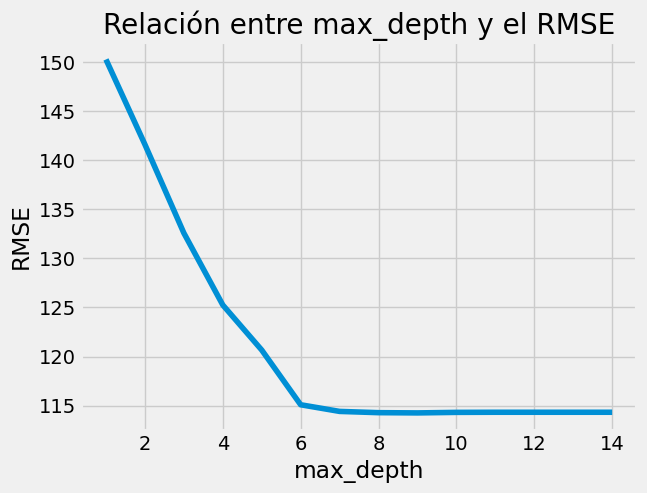

In [ ]:
### Hallar la profundidad optima del arbol (La que obtiene menor RMSE)
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.tree import DecisionTreeRegressor
import matplotlib.pyplot as plt

# Definir variables predictoras (X) y respuesta (y)
X = bikes[['hour', 'season']]
y = bikes['total']

# Dividir datos en entrenamiento (80%) y prueba (20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Configurar validación cruzada con K=5
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Lista de valores para calibrar el criterio de parada de máxima profundidad (max_depth)
max_depth_range = range(1, 15)

# Lista para guardar los valores del RMSE para cada valor de máxima profundidad (max_depth)
rmse_scores = []

# ciclo para obtener el desempeño del modelo de acuerdo con la máxima profundidad
for depth in max_depth_range:
    # Definición del árbol de decisión
    regressor = DecisionTreeRegressor(max_depth=depth, random_state=1)

    # Calcular el error cuadrático medio usando cross_val_score
    mse_scores = cross_val_score(regressor, X, y, cv=kf, scoring='neg_mean_squared_error')  # Negativo para revertir el signo
    rmse_scores.append(((-mse_scores).mean())**0.5)  # Convertir MSE en RMSE

# Gráfica max_depth versus RMSE (error del modelo)
plt.plot(max_depth_range, rmse_scores)
plt.xlabel('max_depth')
plt.ylabel('RMSE')
plt.title('Relación entre max_depth y el RMSE')
plt.show()

Se puede evidenciar como el menor RMSE(Raiz del Error Cuadratico Medio) lo encontramos en el arbol con 9 capas de profundidad, con este parametro procedemos a entrenar y evaluar el arbol de decision.

In [ ]:
#### ENTRENAMIENTO DE ARBOL Y CALCULO DE RMSE

from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
import numpy as np

# Definir el max_depth óptimo según el análisis previo
optimal_depth = max_depth_range[np.argmin(rmse_scores)]  # Encuentra el índice del menor RMSE

# Entrenar el modelo con max_depth óptimo
best_tree = DecisionTreeRegressor(max_depth=optimal_depth, random_state=1)
best_tree.fit(X_train, y_train)  # Entrenar con datos de entrenamiento

# Realizar predicciones en los datos de prueba
y_pred = best_tree.predict(X_test)

# Evaluar el modelo en datos de prueba usando RMSE
test_rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"El RMSE en los datos de prueba es: {test_rmse:.2f}")
print(best_tree)

El RMSE en los datos de prueba es: 115.98
DecisionTreeRegressor(max_depth=9, random_state=1)


In [ ]:
# max_depth=4 fue el mejor, se ajusta un árbol usando este valor
clf = DecisionTreeRegressor(max_depth=9, random_state=1)
clf.fit(X, y)

DecisionTreeRegressor(max_depth=9, random_state=1)

In [ ]:
# Uso de la función .feature_importances_ para obtener la importancia de cada variable
feature_cols = ['hour','season']
pd.DataFrame({'feature':feature_cols, 'importance':clf.feature_importances_}).sort_values('importance')

,feature,importance
1,season,0.13815
0,hour,0.86185


Se evidencia que la mayor relevancia la tiene la variable predictora 'hour', pues tiene un nivel de importancia de 86.2% mientras que la variable 'season' tiene 13.8% de esto se concluye que la variable 'hour' influye mucho mas en la cantidad de bicicletas alquiladas que la estación del año.

## Parte B - Métodos de ensamblajes
En esta parte del taller se usará el conjunto de datos de Popularidad de Noticias Online. El objetivo es predecir si la notica es popular o no, la popularidad está dada por la cantidad de reacciones en redes sociales. Para más detalles puede visitar el siguiente enlace: [datos](https://archive.ics.uci.edu/ml/datasets/online+news+popularity).

### Datos popularidad de noticias

In [ ]:
# Lectura de la información de archivo .csv
df = pd.read_csv('https://raw.githubusercontent.com/davidzarruk/MIAD_ML_NLP_2023/main/datasets/mashable.csv', index_col=0)
df.head()

,url,timedelta,n_tokens_title,n_tokens_content,n_unique_tokens,n_non_stop_words,n_non_stop_unique_tokens,num_hrefs,num_self_hrefs,num_imgs,...,min_positive_polarity,max_positive_polarity,avg_negative_polarity,min_negative_polarity,max_negative_polarity,title_subjectivity,title_sentiment_polarity,abs_title_subjectivity,abs_title_sentiment_polarity,Popular
0,http://mashable.com/2014/12/10/cia-torture-rep...,28.0,9.0,188.0,0.732620,1.0,0.844262,5.0,1.0,1.0,...,0.200000,0.80,-0.487500,-0.60,-0.250000,0.9,0.8,0.4,0.8,1
1,http://mashable.com/2013/10/18/bitlock-kicksta...,447.0,7.0,297.0,0.653199,1.0,0.815789,9.0,4.0,1.0,...,0.160000,0.50,-0.135340,-0.40,-0.050000,0.1,-0.1,0.4,0.1,0
2,http://mashable.com/2013/07/24/google-glass-po...,533.0,11.0,181.0,0.660377,1.0,0.775701,4.0,3.0,1.0,...,0.136364,1.00,0.000000,0.00,0.000000,0.3,1.0,0.2,1.0,0
3,http://mashable.com/2013/11/21/these-are-the-m...,413.0,12.0,781.0,0.497409,1.0,0.677350,10.0,3.0,1.0,...,0.100000,1.00,-0.195701,-0.40,-0.071429,0.0,0.0,0.5,0.0,0
4,http://mashable.com/2014/02/11/parking-ticket-...,331.0,8.0,177.0,0.685714,1.0,0.830357,3.0,2.0,1.0,...,0.100000,0.55,-0.175000,-0.25,-0.100000,0.0,0.0,0.5,0.0,0


In [ ]:
# Definición variable de interes y variables predictoras
X = df.drop(['url', 'Popular'], axis=1)
y = df['Popular']
y.mean()

np.float64(0.5)

In [ ]:
# División de la muestra en set de entrenamiento y prueba
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

### Punto 6 - Árbol de decisión y regresión logística
En la celda 6 construya un árbol de decisión y una regresión logística. Para el árbol calibre al menos un parámetro y evalúe el desempeño de cada modelo usando las métricas de Accuracy y F1-Score.

In [ ]:
# Celda 6
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import accuracy_score, f1_score
import numpy as np

# Dividir datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1, test_size=0.2)

# Rango de valores para max_depth
max_depth_range = range(1, 20)

# Lista para almacenar los puntajes de validación cruzada
accuracy_scores = []

# Probar cada valor de max_depth y evaluar con validación cruzada
for depth in max_depth_range:
    tree = DecisionTreeClassifier(max_depth=depth, random_state=1)
    scores = cross_val_score(tree, X_train, y_train, cv=5, scoring='accuracy')
    accuracy_scores.append(scores.mean())

# Encontrar el mejor max_depth
optimal_depth = max_depth_range[np.argmax(accuracy_scores)]
print(f"El valor óptimo de max_depth es: {optimal_depth}")

# Entrenar el árbol con la profundidad óptima
best_tree = DecisionTreeClassifier(max_depth=optimal_depth, random_state=1)
best_tree.fit(X_train, y_train)

# Predicciones con los datos de prueba
y_pred = best_tree.predict(X_test)

# Evaluación del modelo con métricas Accuracy y F1-Score
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted')

# Mostrar resultados
print(f"Accuracy en test: {accuracy:.4f}")
print(f"F1-Score en test: {f1:.4f}")


El valor óptimo de max_depth es: 1
Accuracy en test: 0.6467
F1-Score en test: 0.6467


Text(0.5, 1.0, 'Matriz de Confusión Arbol')

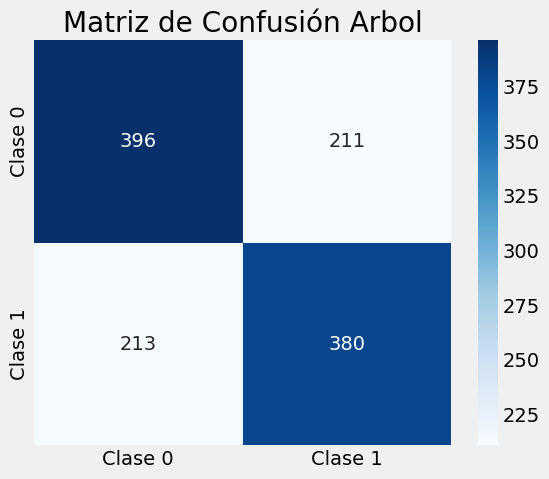

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Calcular la matriz de confusión
conf_matrix = confusion_matrix(y_test, y_pred)

# Graficar la matriz de confusión
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=['Clase 0', 'Clase 1'], yticklabels=['Clase 0', 'Clase 1'])
plt.title('Matriz de Confusión Arbol')

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import train_test_split

# Dividir datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1, test_size=0.2)

# Entrenar el modelo de regresión logística
logreg = LogisticRegression(random_state=1)
logreg.fit(X_train, y_train)

# Predicciones con los datos de prueba
y_pred_logreg = logreg.predict(X_test)

# Evaluación del modelo con métricas Accuracy y F1-Score
accuracy_logreg = accuracy_score(y_test, y_pred_logreg)
f1_logreg = f1_score(y_test, y_pred_logreg, average='weighted')

# Mostrar resultados
print(f"Regresión Logística - Accuracy: {accuracy_logreg:.4f}")
print(f"Regresión Logística - F1-Score: {f1_logreg:.4f}")

Regresión Logística - Accuracy: 0.6208
Regresión Logística - F1-Score: 0.6208


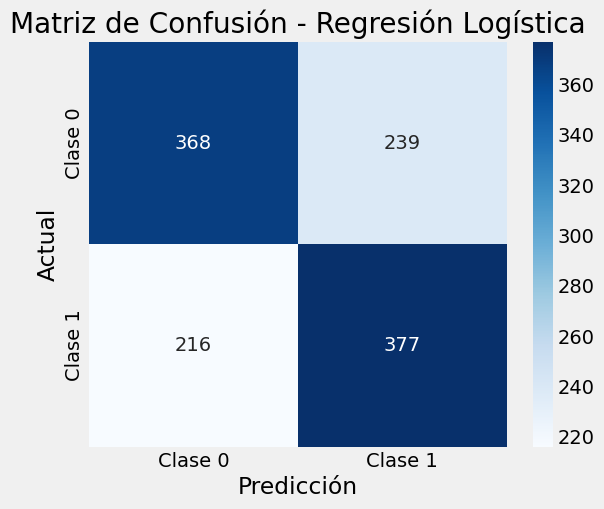

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Calcular la matriz de confusión para el modelo de regresión logística
conf_matrix_logreg = confusion_matrix(y_test, y_pred_logreg)

# Graficar la matriz de confusión
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix_logreg, annot=True, fmt="d", cmap="Blues", xticklabels=['Clase 0', 'Clase 1'], yticklabels=['Clase 0', 'Clase 1'])
plt.title('Matriz de Confusión - Regresión Logística')
plt.xlabel('Predicción')
plt.ylabel('Actual')
plt.show()

#### **ANALISIS Y CONCLUSIONES**

* El Arbol de decisión es el mejor modelo para este caso, pues tiene mejor accuracy (0.6467 vs. 0.6208) y mejor F1-score.

* El valor optimo del parametro max_depth en el arbol de decision es 1, lo que indica que el modelo esta realizando una unica division de los datos, esto sugiere que no se requiere un modelo complejo para clasificar estos datos.

* Un accuracy de 0.64 - 0.62 sugiere que el problema es relativamente desafiante y puede requerir más ajustes o modelos más avanzados.

Ambos modelos tienen resultados similares, pero el Arbol de decision tiene un desempeño ligeramente mejor, analizando las matrices de confusion tambien se infiere que el modelo de regresion logistica comete mas errores que el arbol de decision al identificar correctamente los positivos

### Punto 7 - Votación Mayoritaria
En la celda 7 elabore un esamble con la metodología de **Votación mayoritaria** compuesto por 300 muestras bagged donde:

-las primeras 100 muestras vienen de árboles de decisión donde max_depth tome un valor de su elección\
-las segundas 100 muestras vienen de árboles de decisión donde min_samples_leaf tome un valor de su elección\
-las últimas 100 muestras vienen de regresiones logísticas

Evalúe cada uno de los tres modelos de manera independiente utilizando las métricas de Accuracy y F1-Score, luego evalúe el ensamble de modelos y compare los resultados.

Nota:

Para este ensamble de 300 modelos, deben hacer votación mayoritaria. Esto lo pueden hacer de distintas maneras. La más "fácil" es haciendo la votación "manualmente", como se hace a partir del minuto 5:45 del video de Ejemplo práctico de emsablajes en Coursera. Digo que es la más fácil porque si hacen la votación mayoritaria sobre las 300 predicciones van a obtener lo que se espera.

Otra opción es: para cada uno de los 3 tipos de modelos, entrenar un ensamble de 100 modelos cada uno. Predecir para cada uno de esos tres ensambles y luego predecir como un ensamble de los 3 ensambles. La cuestión es que la votación mayoritaria al usar los 3 ensambles no necesariamente va a generar el mismo resultado que si hacen la votación mayoritaria directamente sobre los 300 modelos. Entonces, para los que quieran hacer esto, deben hacer ese último cálculo con cuidado.

Para los que quieran hacerlo como ensamble de ensambles, digo que se debe hacer el ensamble final con cuidado por lo siguiente. Supongamos que:

* para los 100 árboles del primer tipo, la votación mayoritaria es: 55% de los modelos predicen que la clase de una observación es "1"
* para los 100 árboles del segundo tipo, la votación mayoritaria es: 55% de los modelos predicen que la clase de una observación es "1"
* para las 100 regresiones logísticas, la votación mayoritaria es: 10% de los modelos predicen que la clase de una observación es "1"

Si se hace la votación mayoritaria de los 300 modelos, la predicción de esa observación debería ser: (100*55%+100*55%+100*10%)/300 = 40% de los modelos votan porque la predicción debería ser "1". Es decir, la predicción del ensamble es "0" (dado que menos del 50% de modelos predijo un 1).

Sin embargo, si miramos cada ensamble por separado, el primer ensamble predice "1", el segundo ensamble predice "1" y el último ensamble predice "0". Si hago votación mayoritaria sobre esto, la predicción va a ser "1", lo cual es distinto a si se hace la votación mayoritaria sobre los 300 modelos.

In [ ]:
# Celda 7
# Proporciones de las diferentes clases de variable de interés (y)
y.value_counts().to_frame('Popular').assign(percentage = lambda x: x/x.sum())

,Popular,percentage
Popular,,
1,3000,0.5
0,3000,0.5


In [ ]:
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import accuracy_score, f1_score

# Configuración de semilla
np.random.seed(123)

# Generación de 300 muestras bootstrap
n_estimators = 300
n_samples = X_train.shape[0]
samples = [np.random.choice(a=n_samples, size=n_samples, replace=True) for _ in range(n_estimators)]

# Entrenamiento de modelos individuales
models = []

# 100 Arboles con max_depth=3
for i in range(100):
    tree = DecisionTreeClassifier(max_depth=3, random_state=np.random.randint(1, 10000))
    tree.fit(X_train.iloc[samples[i]], y_train.iloc[samples[i]])
    models.append(("tree_depth_" + str(i), tree))

# 100 Arboles con min_samples_leaf=5
for i in range(100, 200):
    tree = DecisionTreeClassifier(min_samples_leaf=5, random_state=np.random.randint(1, 10000))
    tree.fit(X_train.iloc[samples[i]], y_train.iloc[samples[i]])
    models.append(("tree_leaf_" + str(i), tree))

# 100 Modelos de Regresion Logistica
for i in range(200, 300):
    log_reg = LogisticRegression(max_iter=1000, random_state=np.random.randint(1, 10000))
    log_reg.fit(X_train.iloc[samples[i]], y_train.iloc[samples[i]])
    models.append(("log_reg_" + str(i), log_reg))

In [ ]:
# Funcion para evaluar un conjunto de modelos
def evaluate_models(models_subset):
    predictions = np.array([model.predict(X_test) for model in models_subset])
    majority_vote = np.round(predictions.mean(axis=0))
    accuracy = accuracy_score(y_test, majority_vote)
    f1 = f1_score(y_test, majority_vote)
    return accuracy, f1

# Evaluación individual de cada grupo
acc_tree_depth, f1_tree_depth = evaluate_models([m[1] for m in models[:100]])
acc_tree_leaf, f1_tree_leaf = evaluate_models([m[1] for m in models[100:200]])
acc_log_reg, f1_log_reg = evaluate_models([m[1] for m in models[200:]])

print(f"Árboles (max_depth=3) -> Accuracy: {acc_tree_depth:.4f}, F1-Score: {f1_tree_depth:.4f}")
print(f"Árboles (min_samples_leaf=5) -> Accuracy: {acc_tree_leaf:.4f}, F1-Score: {f1_tree_leaf:.4f}")
print(f"Regresión Logística -> Accuracy: {acc_log_reg:.4f}, F1-Score: {f1_log_reg:.4f}")

Árboles (max_depth=3) -> Accuracy: 0.6517, F1-Score: 0.6440
Árboles (min_samples_leaf=5) -> Accuracy: 0.6525, F1-Score: 0.6469
Regresión Logística -> Accuracy: 0.6150, F1-Score: 0.6010


In [ ]:
# Ensamble con votación mayoritaria
voting_clf = VotingClassifier(estimators=models, voting='hard')
voting_clf.fit(X_train, y_train)

# Predicción y evaluación del ensamble
y_pred_ensemble = voting_clf.predict(X_test)
acc_ensemble = accuracy_score(y_test, y_pred_ensemble)
f1_ensemble = f1_score(y_test, y_pred_ensemble)

print(f"Ensamble -> Accuracy: {acc_ensemble:.4f}, F1-Score: {f1_ensemble:.4f}")

Ensamble -> Accuracy: 0.6458, F1-Score: 0.6262


### Punto 8 - Votación Ponderada
En la celda 8 elabore un ensamble con la metodología de **Votación ponderada** compuesto por 300 muestras bagged para los mismos tres escenarios del punto 7. Evalúe los modelos utilizando las métricas de Accuracy y F1-Score

In [ ]:
# Celda 8
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import accuracy_score, f1_score

# Configuración de reproducibilidad
np.random.seed(123)

# Generación de 300 muestras bootstrap
n_estimators = 300
n_samples = X_train.shape[0]
samples = [np.random.choice(a=n_samples, size=n_samples, replace=True) for _ in range(n_estimators)]

# Entrenamiento de modelos individuales
models = []

# 100 Árboles con max_depth=3
for i in range(100):
    tree = DecisionTreeClassifier(max_depth=3, random_state=np.random.randint(1, 10000))
    tree.fit(X_train.iloc[samples[i]], y_train.iloc[samples[i]])
    models.append(("tree_depth_" + str(i), tree))

# 100 Árboles con min_samples_leaf=5
for i in range(100, 200):
    tree = DecisionTreeClassifier(min_samples_leaf=5, random_state=np.random.randint(1, 10000))
    tree.fit(X_train.iloc[samples[i]], y_train.iloc[samples[i]])
    models.append(("tree_leaf_" + str(i), tree))

# 100 Modelos de Regresión Logística
for i in range(200, 300):
    log_reg = LogisticRegression(max_iter=1000, random_state=np.random.randint(1, 10000))
    log_reg.fit(X_train.iloc[samples[i]], y_train.iloc[samples[i]])
    models.append(("log_reg_" + str(i), log_reg))

In [ ]:
# Función para evaluar un conjunto de modelos
def evaluate_models(models_subset):
    predictions = np.array([model.predict(X_test) for model in models_subset])
    majority_vote = np.round(predictions.mean(axis=0))  # Votación mayoritaria
    accuracy = accuracy_score(y_test, majority_vote)
    f1 = f1_score(y_test, majority_vote)
    return accuracy, f1

# Evaluación individual
acc_tree_depth, f1_tree_depth = evaluate_models([m[1] for m in models[:100]])
acc_tree_leaf, f1_tree_leaf = evaluate_models([m[1] for m in models[100:200]])
acc_log_reg, f1_log_reg = evaluate_models([m[1] for m in models[200:]])

print(f"Árboles (max_depth=3) -> Accuracy: {acc_tree_depth:.4f}, F1-Score: {f1_tree_depth:.4f}")
print(f"Árboles (min_samples_leaf=5) -> Accuracy: {acc_tree_leaf:.4f}, F1-Score: {f1_tree_leaf:.4f}")
print(f"Regresión Logística -> Accuracy: {acc_log_reg:.4f}, F1-Score: {f1_log_reg:.4f}")

Árboles (max_depth=3) -> Accuracy: 0.6517, F1-Score: 0.6440
Árboles (min_samples_leaf=5) -> Accuracy: 0.6525, F1-Score: 0.6469
Regresión Logística -> Accuracy: 0.6150, F1-Score: 0.6010


In [ ]:
# Normalización de pesos con base en F1-Score
total_f1 = f1_tree_depth + f1_tree_leaf + f1_log_reg
weights = {
    "tree_depth": f1_tree_depth / total_f1,
    "tree_leaf": f1_tree_leaf / total_f1,
    "log_reg": f1_log_reg / total_f1
}

print(f"Pesos asignados - Árboles (max_depth=3): {weights['tree_depth']:.3f}, "
      f"Árboles (min_samples_leaf=5): {weights['tree_leaf']:.3f}, "
      f"Regresión Logística: {weights['log_reg']:.3f}")

Pesos asignados - Árboles (max_depth=3): 0.340, Árboles (min_samples_leaf=5): 0.342, Regresión Logística: 0.318


In [ ]:
# Creación del ensamble con votación ponderada
weighted_voting_clf = VotingClassifier(
    estimators=models,
    voting='soft',  # Votación ponderada
    weights=[weights["tree_depth"]] * 100 + [weights["tree_leaf"]] * 100 + [weights["log_reg"]] * 100
)

# Entrenamiento del ensamble
weighted_voting_clf.fit(X_train, y_train)

# Predicción y evaluación del ensamble ponderado
y_pred_weighted = weighted_voting_clf.predict(X_test)
acc_weighted = accuracy_score(y_test, y_pred_weighted)
f1_weighted = f1_score(y_test, y_pred_weighted)

print(f"Ensamble Ponderado -> Accuracy: {acc_weighted:.4f}, F1-Score: {f1_weighted:.4f}")

Ensamble Ponderado -> Accuracy: 0.6383, F1-Score: 0.6377


### Punto 9 - Comparación y análisis de resultados
En la celda 9 comente sobre los resultados obtenidos con las metodologías usadas en los puntos 7 y 8, compare los resultados y enuncie posibles ventajas o desventajas de cada una de ellas.

#### **ANALISIS DE ENSAMBLES**
* Se entrenan 300 modelos en total: 100 Arboles de decision con parametro max_depth = 3, 100 Arboles de decision con parametro min_samples_leaf = 5, 100 modelos de regresion logistica.
* Los arboles de decision obtuvieron mejor desempeño que la regresión logistica en accuracy y F1-score, con valores de 0.65 y 0.64 respectivamente, mientras que el modelo de regresion obtuvo 0.61 y 0.6.
* El Ensamble con Votacion Mayoritaria tiene mejor Accuracy 0.645 vs 0.638 del votacion Ponderada, pero ocurre lo contrario en el F1-Score tiene menor 0.626 vs 0.637 del Ponderado. De esto se puede interpretar que el Ensamble Ponderado tiene mejor balance entre precision y recall.
* La Votacion Ponderada dio mas peso a los arboles pero el impacto fue limitado, Arboles: 34%, Reg log: 31.8%.

#### **CONCLUSIONES**
* Si se prioriza el Accuracy, el Ensamble de Votacion Mayoritaria es la mejor opcion mientras que si se prioriza el F1-Score, el Ensamble Ponderado es mejor.
* Se puede mejorar el ensamble reduciendo el peso del modelo de regresion logistica o excluirla si se evidencia una afectacion negativa del modelo.